# Functional Connectivity Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import networkx as nx

In [2]:
# Little function for the Lorenz Curve.
# Credit to https://gist.github.com/CMCDragonkai
def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

In [3]:
def ecdf(raw_data):
    '''[np.array -> tuple]
    Equivalent to R's ecdf(). Credit to Kripanshu Bhargava from Codementor'''
    cdfx = np.unique(raw_data)
    x_values = np.linspace(start=min(cdfx), stop=max(cdfx), num=len(cdfx))
    size_data = raw_data.size
    y_values = []
    for i in x_values:
        # all the values in raw data less than the ith value in x_values
        temp = raw_data[raw_data <= i]
        # fraction of that value with respect to the size of the x_values
        value = temp.size / size_data

        y_values.append(value)

    return (x_values, y_values)

In [6]:
# FIRST: STTCs REPRODUCES LOG-NORMAL DISTRIBUTION OF CA3 CONNECTIVITY
# (Ikegaya, cerebral cortex 2012).
eg_WT = pd.read_csv('/Users/labc02/Documents/PDCB_data/STTC_data/STTC_Basal/CA3_WT_male_02117_merged_sp-02STTC').drop(columns=['Unnamed: 0'])
loren_arr = lorenz(np.sort(np.array(eg_WT['STTC_weight'][eg_WT['STTC_weight'] > 0])))

Text(0.5, 0, 'STTC ordered')

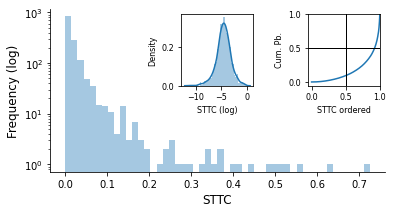

In [179]:
lgnl_fig = plt.figure(figsize= (6,3))
ax = lgnl_fig.add_subplot(1,1,1)
sns.distplot(eg_WT['STTC_weight'][eg_WT['STTC_weight'] > 0], kde = False)
plt.yscale('log')
plt.xlabel('STTC', fontsize = 12)
plt.ylabel('Frequency (log)', fontsize = 12)
sns.despine()
in_ax = inset_axes(ax, width = 1, height = 1, loc = 'upper center')
sns.distplot(np.log(eg_WT['STTC_weight'][eg_WT['STTC_weight'] > 0]))
plt.xticks([-10, -5, 0], fontsize = 8)
plt.yticks([0.0, 0.2, 0.4], fontsize = 8)
plt.ylabel('Density', fontsize = 8)
plt.xlabel('STTC (log)', fontsize = 8)
in_ax.axis('tight')
in_ax2 = inset_axes(ax, width = 1, height = 1, loc = 'upper right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes)
in_ax2.axis('tight')
plt.plot(np.linspace(0.0, 1.0, loren_arr.size), loren_arr)
plt.yticks([0.0, 0.50, 1.00], fontsize = 8)
plt.xticks([0.0, 0.5, 1.00], fontsize = 8)
plt.axhline(0.50, color = 'k', linewidth = 1)
plt.axvline(0.50, color = 'k', linewidth = 1)
#plt.title('Lorenz Curve', fontsize = 8)
plt.ylabel('Cum. Pb.', fontsize = 8)
plt.xlabel('STTC ordered', fontsize = 8)

In [180]:
lgnl_fig.savefig('/Users/labc02/Documents/PDCB_data/Behavior/Figures/lorenz_fig.svg')

In [41]:
# NOW, REPRODUCE PREVIOUS RESULTS
tidy_df = pd.read_csv('/Users/labc02/Documents/PDCB_data/STTC_data/tidy_STTC.csv')

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


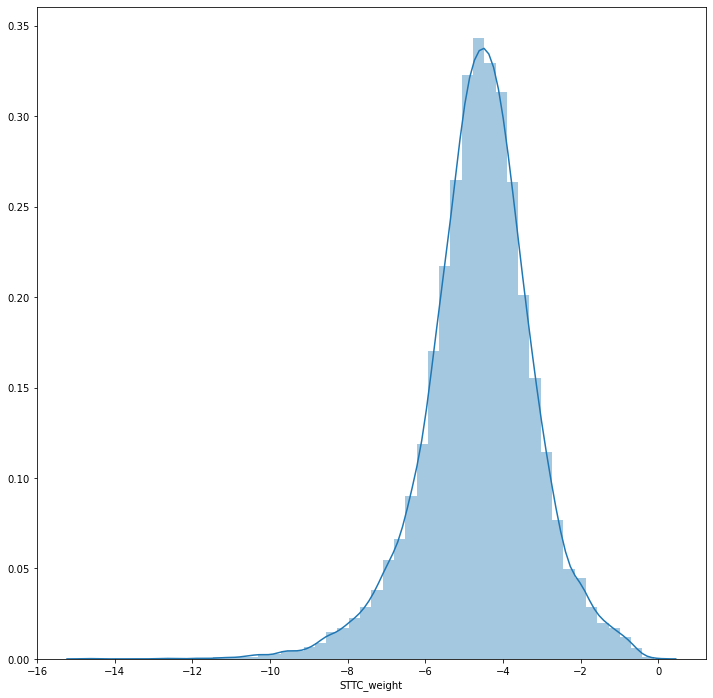

In [42]:
plt.figure(figsize=(12,12))
sns.distplot(np.log(tidy_df['STTC_weight'][tidy_df['Gen_type'] == 'WT']).dropna())

In [43]:
# Analyzing only positive values
All_pos = tidy_df['STTC_weight'][tidy_df['STTC_weight'] > 0]
All_WT = tidy_df['STTC_weight'][(tidy_df['Gen_type'] == 'WT') & (tidy_df['STTC_weight'] > 0)]
All_KO = tidy_df['STTC_weight'][(tidy_df['Gen_type']  == 'KO') & (tidy_df['STTC_weight'] > 0)]

In [44]:
# Determining groups and global threshold

WT_pos_th = (3*sm.robust.scale.mad(All_WT[All_WT > 0])+All_WT.median()).round(3)
KO_pos_th = (3*sm.robust.scale.mad(All_KO[All_KO > 0])+All_KO.median()).round(3)
Global_th = 3*sm.robust.scale.mad(All_pos)+ All_pos.median()
Global_th.round(3)

0.047

In [45]:
WT_pos_th

0.043

In [46]:
KO_pos_th

0.051

In [47]:
# ECDF time
cdf_wt = np.sort(np.unique(All_WT[All_WT >= Global_th.round(3)].values))
cdf_ko = np.sort(np.unique(All_KO[All_KO >= Global_th.round(3)].values))

wt_values = np.linspace(start=min(cdf_wt), stop=max(cdf_wt), num=len(cdf_wt))

ko_values = np.linspace(start=min(cdf_ko), stop=max(cdf_ko), num=len(cdf_ko))

wt_size = All_WT[All_WT >= Global_th.round(3)].size
ko_size = All_KO[All_KO >= Global_th.round(3)].size
wt_z = []
ko_z = []

for ii in wt_values:
    temp = All_WT[All_WT >= Global_th.round(3)][All_WT[All_WT >= Global_th.round(3)]< ii]
    fn_x = temp.size / wt_size
    wt_z.append(fn_x)
for ii in ko_values:
    temp = All_KO[All_KO >= Global_th.round(3)][All_KO[All_KO >= Global_th.round(3)]< ii]
    fn_x = temp.size / ko_size
    ko_z.append(fn_x)

<ipython-input-206-564d2d971d06>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


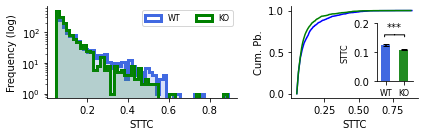

In [206]:
# EDGES WEIGHTS DISTRIBUTIONS
agg_sig, (a0, a1) =  plt.subplots(1,2, gridspec_kw = {'width_ratios':[1.5, 1]}, figsize=(6,2))
sns.distplot(All_WT[All_WT >= Global_th.round(3)], kde = False, norm_hist = False, color = 'royalblue', hist_kws = {'histtype': 'bar', 'linewidth': 3, 'alpha':0.2}, ax = a0)
sns.distplot(All_WT[All_WT >= Global_th.round(3)], kde = False, norm_hist = False, color = 'royalblue', hist_kws = {'histtype': 'step', 'linewidth': 3, 'alpha' : 1}, ax= a0, label = 'WT')
sns.distplot(All_KO[All_KO >= Global_th.round(3)], kde = False, norm_hist = False, color = 'green', hist_kws = {'histtype': 'step', 'linewidth': 3, 'alpha' : 1}, ax = a0, label = 'KO')
sns.distplot(All_KO[All_KO >= Global_th.round(3)], kde = False, norm_hist = False, color = 'forestgreen', hist_kws = {'histtype': 'bar', 'linewidth': 4, 'alpha': 0.2}, ax = a0)
a0.set_yscale('log')
a0.set_ylabel('Frequency (log)')
a0.set_xlabel('STTC')
sns.despine()
a0.legend(ncol = 2, prop={'size': 8}, fontsize = 4)
a1.plot(wt_values, wt_z, color = 'b')
a1.plot(ko_values, ko_z, color = 'g')
a1.set_xlabel('STTC')
a1.set_ylabel('Cum. Pb.')


in_a1 = inset_axes(a1, width = .5, height = .8, loc = 7)
plt.bar((.5), All_WT[All_WT >= Global_th.round(3)].mean(), yerr= (All_WT[All_WT >= Global_th.round(3)].sem()), capsize = 3, color ='royalblue', width = 0.5)
plt.bar((1.5), All_KO[All_KO >= Global_th.round(3)].mean(), yerr = All_KO[All_KO >= Global_th.round(3)].sem(), capsize = 3, color = 'forestgreen', width = 0.5)
plt.xticks((.5, 1.5), ['WT', 'KO'], fontsize = 8)
in_a1.spines['right'].set_visible(False)
in_a1.spines['top'].set_visible(False)
plt.xlim(0,2)
plt.ylim(0, .2)
plt.ylabel('STTC', fontsize = 8)
in_a1.annotate('***', xy=(0.5, .8), xytext=(0.5, .84), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom', arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=0.2', lw=1))
plt.tight_layout()


In [70]:
sp.stats.mannwhitneyu(All_WT[All_WT >= Global_th.round(3)], All_KO[All_KO >= Global_th.round(3)], alternative = 'two-sided')

MannwhitneyuResult(statistic=1191027.0, pvalue=0.001137509260268912)

In [207]:
agg_sig.savefig('/Users/labc02/Documents/PDCB_data/Behavior/Figures/STTC_comparison_paper.svg')

### DEGREES DISTRIBUTION ANALYSIS

In [98]:
graph_df = tidy_df.drop(columns=['Unnamed: 0', 'Sex', 'STTC_boots', 'STTC_TBS', 'STTC_PostTBS'])
Gl_th = Global_th.round(3)
g_names = graph_df['Date'].unique()
g_names


wt_degs = []
ko_degs = []
wt_wedegs = []
ko_wedegs = []

for ii in g_names:
    ex_g =  graph_df[['Gen_type', 'Node_1', 'Node_2', 'STTC_weight']][(graph_df['Date'] == ii) & (graph_df['STTC_weight'] >= Gl_th)]
    ex_gr = nx.from_pandas_edgelist(df = ex_g, source = 'Node_1', target = 'Node_2',  edge_attr = True)
    if ex_g['Gen_type'].unique()  == 'WT':
        wt_degs += list(dict(nx.degree(ex_gr)).values())
        wt_wedegs +=list(dict(nx.degree(ex_gr, weight = 'STTC_weight')).values())
    elif ex_g['Gen_type'].unique()  == 'KO':
        ko_degs += list(dict(nx.degree(ex_gr)).values())
        ko_wedegs += list(dict(nx.degree(ex_gr, weight = 'STTC_weight')).values())

In [99]:
degrees_df = pd.DataFrame(data = [wt_degs, ko_degs, wt_wedegs, ko_wedegs])
degrees_df = degrees_df.T
degrees_df.columns = ['WT_uw', 'KO_uw', 'WT_w', 'KO_w']

hist, bins = np.histogram(degrees_df['KO_uw'].dropna(), bins = 'auto', density = True)
hist, bins
np.cumsum(hist)
center = (bins[:-1] + bins[1:]) / 2
len(center)
np.insert(bins, 0, 0)
1-np.cumsum(hist)
len(1-np.cumsum(hist)), len(bins)
len(hist), len(bins)

(21, 22)

In [100]:
# FUNCTIONS TO FIT DISTRIBUTIONS
def powerlaw(x, g):
    return x**-g
def myexp(x, g):
    return np.exp(-g*x)
def trunc_power(x, g, k):
    return x**-g * np.exp(-x/k)

[-0.26145241  3.65528499]
[0.04560242 6.83127185]


Text(0, 0.5, 'log P(degree > k)')

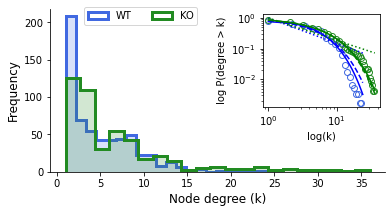

In [186]:
S_fits = {}
#%%
degrees_fig = plt.figure(figsize= (6,3))
deg_1 = plt.subplot(1,1,1)
sns.distplot(degrees_df['WT_uw'].dropna(), kde = False, color = 'royalblue', hist_kws = {'histtype': 'step', 'linewidth': 3, 'alpha' : 1}, bins = 'auto', norm_hist = False, label = 'WT')
sns.distplot(degrees_df['WT_uw'].dropna(), kde = False, color = 'royalblue', hist_kws = {'histtype': 'bar', 'linewidth': 3, 'alpha':0.2}, bins = 'auto', norm_hist = False)
sns.distplot(degrees_df['KO_uw'].dropna(), kde = False, bins = 'auto', norm_hist = False, color = 'forestgreen', hist_kws = {'histtype': 'step', 'linewidth': 3, 'alpha' : 1}, label = 'KO')
sns.distplot(degrees_df['KO_uw'].dropna(), kde = False, bins = 'auto', norm_hist = False, color = 'forestgreen', hist_kws = {'histtype': 'bar', 'linewidth': 4, 'alpha': 0.2})
sns.despine()
plt.xlabel('Node degree (k)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = (.1, .9), ncol = 2)
inset_axes(deg_1, width = '35%', height = 1.3)
wu_ecdf = ecdf(degrees_df['WT_uw'].dropna())
wu_cCDf = 1-np.array(wu_ecdf[1])
plt.plot(wu_ecdf[0], wu_cCDf, color = 'royalblue', marker = 'o', mfc = 'none', linestyle = '')
ku_ecdf = ecdf(degrees_df['KO_uw'].dropna())
ku_cCDf = 1-np.array(ku_ecdf[1])
plt.plot(ku_ecdf[0], ku_cCDf, color = 'forestgreen', marker = 'o', mfc = 'none', linestyle = '')
sp.stats.ks_2samp(degrees_df['WT_uw'].dropna(), degrees_df['KO_uw'].dropna())
#plt.text(1, .002, r'$p$ ≤ 0.05')
popt,pcov =  sp.optimize.curve_fit(powerlaw, wu_ecdf[0], wu_cCDf)
plt.plot(wu_ecdf[0], powerlaw(wu_ecdf[0], popt), 'b:')
S_fits['power_wt'] = np.sqrt(np.sum(((wu_cCDf)-powerlaw(wu_ecdf[0], popt))**2)/(len(wu_cCDf)-1))
popt,pcov =  sp.optimize.curve_fit(myexp, wu_ecdf[0], wu_cCDf)
plt.plot(wu_ecdf[0], myexp(wu_ecdf[0], popt), 'b--')
S_fits['exp_wt'] = np.sqrt(np.sum(((wu_cCDf)-myexp(wu_ecdf[0], popt))**2)/(len(wu_cCDf)-1))
popt,pcov =  sp.optimize.curve_fit(trunc_power, wu_ecdf[0], wu_cCDf)
plt.plot(wu_ecdf[0], trunc_power(wu_ecdf[0], popt[0], popt[1]), 'b-')
print(popt)
S_fits['trpower_wt'] = np.sqrt(np.sum(((wu_cCDf)-trunc_power(wu_ecdf[0], popt[0], popt[1]))**2)/(len(wu_cCDf)-1))
popt,pcov =  sp.optimize.curve_fit(powerlaw, ku_ecdf[0], ku_cCDf)
plt.plot(ku_ecdf[0], powerlaw(ku_ecdf[0], popt), 'g:')
popt,pcov =  sp.optimize.curve_fit(myexp, ku_ecdf[0], ku_cCDf)
S_fits['power_ko'] = np.sqrt(np.sum(((ku_cCDf)-powerlaw(ku_ecdf[0], popt))**2)/(len(ku_cCDf)-1))
plt.plot(ku_ecdf[0], myexp(ku_ecdf[0], popt), 'g--')
S_fits['exp_ko'] = np.sqrt(np.sum(((ku_cCDf)-myexp(ku_ecdf[0], popt))**2)/(len(ku_cCDf)-1))
popt,pcov =  sp.optimize.curve_fit(trunc_power, ku_ecdf[0], ku_cCDf)
plt.plot(ku_ecdf[0], trunc_power(ku_ecdf[0], popt[0], popt[1]), 'g-')
S_fits['trpower_ko'] = np.sqrt(np.sum(((ku_cCDf)-trunc_power(ku_ecdf[0], popt[0], popt[1]))**2)/(len(ku_cCDf)-1))
print(popt)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log(k)')
plt.ylabel('log P(degree > k)')



In [110]:
S_fits

{'power_wt': 0.10586052592134176,
 'exp_wt': 0.028734111813855746,
 'trpower_wt': 0.018397281000676263,
 'power_ko': 0.519948042807207,
 'exp_ko': 0.01217060252828691,
 'trpower_ko': 0.011393859348290283}

In [187]:
degrees_fig.savefig('/Users/labc02/Documents/PDCB_data/Behavior/Figures/degree_dist.svg')

## PROPORTION OF CONNECTED AND FRAGMENTED GRAPHS

In [123]:
# Might need an obnibus tests, most likely ANOVA
g_dic = {'Date': [], 'Gen_type': [], 'No. Nodes': [], 'No. Edges': [], 'Density': [], 'Av. Degree': [], 'Node Conn': [], 'Clustering': [], 'Clustering_W': [], 'Char Path' : [], 'Char Path_w' : [], 'Global Eff' : [], 'Major C': [], 'Degree Cent' : [], 'Sigma' : [], 'Omega' : []}

for ii in g_names:
    print(ii)
    g_df = graph_df[graph_df['Date'] == ii]
    g_th = g_df[['Node_1', 'Node_2', 'STTC_weight']][g_df['STTC_weight'] >= Gl_th]
    g_th['STTC_weight'] = g_th['STTC_weight'].round(3)
    g_th['STTC_rec'] = 1/g_th['STTC_weight'].round(3)
    temp_g = nx.from_pandas_edgelist(df = g_th, source = 'Node_1', target = 'Node_2',  edge_attr = True)

    if nx.is_empty(temp_g) == True:
        print(ii, 'is empty!!!!')

    else:
        g_dic['Date'].append(g_df['Date'].unique()[0])
        g_dic['Gen_type'].append(g_df['Gen_type'].unique()[0])
        g_dic['No. Nodes'].append(nx.number_of_nodes(temp_g))
        g_dic['No. Edges'].append(nx.number_of_edges(temp_g))
        g_dic['Density'].append(nx.density(temp_g))
        g_dic['Av. Degree'].append(round(sum(dict(temp_g.degree()).values())/float(nx.number_of_nodes(temp_g)), 2))
        g_dic['Degree Cent'].append(round(sum(dict(nx.degree_centrality(temp_g)).values())/float(nx.number_of_nodes(temp_g)), 2))
        g_dic['Node Conn'].append(nx.node_connectivity(temp_g))
        g_dic['Clustering'].append(nx.average_clustering(temp_g))
        g_dic['Clustering_W'].append(nx.average_clustering(temp_g, weight = 'STTC_rec'))
        if nx.is_connected(temp_g) == True:
            g_dic['Char Path'].append(nx.average_shortest_path_length(temp_g))
            g_dic['Char Path_w'].append(nx.average_shortest_path_length(temp_g, weight = 'STTC_rec'))
            g_dic['Global Eff'].append(nx.global_efficiency(temp_g))
            g_dic['Major C'].append(nx.number_of_nodes(temp_g)/nx.number_of_nodes(temp_g)*100)
            g_dic['Sigma'].append(nx.sigma(temp_g))
            g_dic['Omega'].append(nx.omega(temp_g))
        else:
            print(ii, 'is not connected')
            Gc = temp_g.subgraph(max(nx.connected_components(temp_g), key=len)).copy()
            g_dic['Char Path'].append(nx.average_shortest_path_length(Gc))
            g_dic['Char Path_w'].append(nx.average_shortest_path_length(Gc, weight = 'STTC_rec'))
            g_dic['Global Eff'].append(nx.global_efficiency(Gc))
            g_dic['Major C'].append(nx.number_of_nodes(Gc)/nx.number_of_nodes(temp_g)*100)
            g_dic['Sigma'].append(nx.sigma(Gc))
            g_dic['Omega'].append(nx.omega(Gc))


21117
291117
301117
301117 is not connected
70218
70218 is not connected
80218
80218 is not connected
121217
140218(b)
140218
140218 is not connected
170218
22117
28117
28117 is not connected
1117
1117 is not connected
7117
91117
91117 is not connected
111217
111217 is not connected
151117
161117
161117 is not connected
201017
201017 is not connected
311017
311017 is not connected
2117
2117 is not connected
61217
61217 is not connected
71217
71217 is not connected
81117
81117 is not connected
131217
131217 is not connected
171117
171117 is not connected


/opt/miniconda3/envs/databs/lib/python3.8/site-packages/networkx/algorithms/smallworld.py:305: RuntimeWarning: invalid value encountered in double_scalars
  sigma = (C / Cr) / (L / Lr)
/opt/miniconda3/envs/databs/lib/python3.8/site-packages/networkx/algorithms/smallworld.py:380: RuntimeWarning: invalid value encountered in double_scalars
  omega = (Lr / L) - (C / Cl)


251017
251017 is not connected
271017
271017 is not connected


In [124]:
g_df = pd.DataFrame(g_dic)
g_df = g_df.drop(24) # outlier, only 10 nodes

wt_con = g_df['Gen_type'][(g_df['Major C']== 100) & (g_df['Gen_type'] == 'WT')].count()
wt_disc = g_df['Gen_type'][(g_df['Major C']< 100) & (g_df['Gen_type'] == 'WT')].count()
ko_con = g_df['Gen_type'][(g_df['Major C']== 100) & (g_df['Gen_type'] == 'KO')].count()
ko_disc = g_df['Gen_type'][(g_df['Major C']< 100) & (g_df['Gen_type'] == 'KO')].count()

In [126]:
cont_tab = np.array([[wt_con, wt_disc], [ko_con, ko_disc]])
sp.stats.fisher_exact(cont_tab)

disconnected_Nxs = (g_df['Gen_type'][(g_df['Major C']< 100) & (g_df['Gen_type'] == 'WT')].count()/g_df['Gen_type'][g_df['Gen_type'] == 'WT'].count()).round(2), (g_df['Gen_type'][(g_df['Major C']< 100) & (g_df['Gen_type'] == 'KO')].count()/g_df['Gen_type'][g_df['Gen_type'] == 'KO'].count()).round(2)

connected_Nxs = (g_df['Gen_type'][(g_df['Major C']== 100) & (g_df['Gen_type'] == 'WT')].count()/g_df['Gen_type'][g_df['Gen_type'] == 'WT'].count()).round(2), (g_df['Gen_type'][(g_df['Major C']== 100) & (g_df['Gen_type'] == 'KO')].count()/g_df['Gen_type'][g_df['Gen_type'] == 'KO'].count()).round(2)


rep_graphs = ['151117', '161117', '61217', '22117', '140218(b)', '140218']

In [127]:
# Fisher's exact test
sp.stats.fisher_exact(cont_tab)

(0.1282051282051282, 0.038443935926773275)

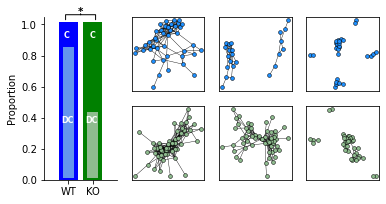

In [224]:
# CONNECTED/DISCONNECTED FIGURE
frag_prop = plt.figure(figsize = (6,3))
fr_ax = plt.subplot2grid((2, 4), (0, 0), rowspan = 2)
plt.bar((1, 1.5), disconnected_Nxs, color = ['cornflowerblue', 'darkseagreen'], width = .3, edgecolor = ['b', 'g'], linewidth = 4, label = 'Disconnected')
plt.bar((1, 1.5), connected_Nxs, bottom = disconnected_Nxs, color = ['b', 'green'], width = .3, edgecolor = ['b', 'g'], linewidth = 4, label = 'Connected')
plt.xticks((1,1.5), ['WT', 'KO'], fontsize = 10)
plt.xlim(0.5, 2)
plt.ylabel('Proportion', fontsize = (10))
fr_ax.spines['top'].set_visible(False)
fr_ax.spines['right'].set_visible(False)
fr_ax.annotate('*', xy=(0.5, 1.0), xytext=(0.5, 1), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom', fontweight = 'bold', arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1))
fr_ax.annotate('C', xy=(.2, .85), xytext=(.27, .87), xycoords='axes fraction',fontsize= 8, color = 'white', fontweight ='bold')
fr_ax.annotate('DC', xy=(.2, .2), xytext=(.24, .35), xycoords='axes fraction',fontsize= 8, color = 'white', fontweight = 'bold')
fr_ax.annotate('C', xy=(.26, .85), xytext=(.63, .87), xycoords='axes fraction',fontsize= 8, color = 'white', fontweight ='bold')
fr_ax.annotate('DC', xy=(.26, .2), xytext=(.57, .35), xycoords='axes fraction',fontsize= 8, color = 'white', fontweight = 'bold')
other_ax = plt.subplot2grid((2,2), (0, 1), rowspan = 2)
_r = 1
_wc = 1
_kc = 1
for ii in rep_graphs:
    g_df = graph_df[graph_df['Date'] == ii]
    g_th = g_df[['Node_1', 'Node_2', 'STTC_weight']][g_df['STTC_weight'] >= Gl_th]
    g_th['STTC_weight'] = g_th['STTC_weight'].round(3)
    temp_g = nx.from_pandas_edgelist(df = g_th, source = 'Node_1', target = 'Node_2',  edge_attr = True)

    if g_df['Gen_type'].unique() == 'KO':
        _r = 1
        kx = plt.subplot2grid((2, 4), (_r, _kc))
        nx.draw_networkx(temp_g, node_size = 15, node_color = 'darkseagreen', linewidths = .5, width = .4, ax = kx, with_labels = False)
        kx.collections[0].set_edgecolor("k")
        plt.xticks([])
        plt.yticks([])
        _kc += 1
    elif g_df['Gen_type'].unique() == 'WT':
        _r = 0
        wx =  plt.subplot2grid((2,4), (_r, _wc))
        nx.draw_networkx(temp_g, node_size = 15, node_color = 'dodgerblue', linewidths = .5, width = .4 , ax = wx, with_labels = False)
        wx.collections[0].set_edgecolor("k")
        plt.xticks([])
        plt.yticks([])
        _wc += 1

In [225]:
frag_prop.savefig('/Users/labc02/Documents/PDCB_data/Behavior/Figures/fragmentation_prop_paper.svg')

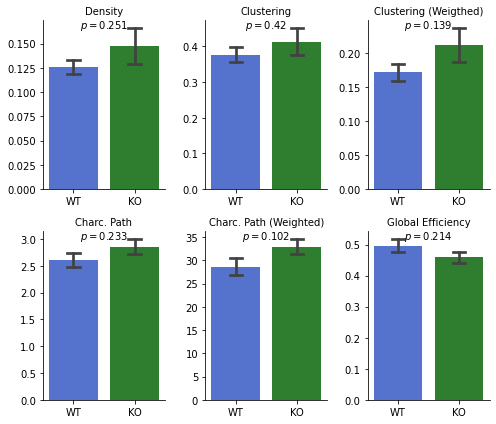

In [150]:
# Clustering, Weighted Cluestring, Charactheristic Path (W) and Global Eff
#%%
g_df = pd.DataFrame(g_dic)
g_df = g_df.drop(24) # outlier, only 10 nodes

g_paramsFig = plt.figure(figsize=(7, 6))
dens_ax = plt.subplot(2,3,1)
sns.barplot('Gen_type', 'Density', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Density'][g_df['Gen_type'] == 'WT'], g_df['Density'][g_df['Gen_type'] == 'KO'])[1]
dens_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.5, .93), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Density', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
clus_ax = plt.subplot(2, 3, 2)
sns.barplot('Gen_type', 'Clustering', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Clustering'][g_df['Gen_type'] == 'WT'], g_df['Clustering'][g_df['Gen_type'] == 'KO'])[1]
clus_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.5, .93), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Clustering', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
clusW_ax = plt.subplot(2,3,3)
sns.barplot('Gen_type', 'Clustering_W', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Clustering_W'][g_df['Gen_type'] == 'WT'], g_df['Clustering_W'][g_df['Gen_type'] == 'KO'], equal_var = True)[1]
clusW_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.5, .95), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Clustering (Weigthed)', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
chpth_ax = plt.subplot(2,3,4)
sns.barplot('Gen_type', 'Char Path', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Char Path'][g_df['Gen_type'] == 'WT'], g_df['Char Path'][g_df['Gen_type'] == 'KO'], equal_var = True)[1]
chpth_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.7, .95), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Charc. Path', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
chpthW_ax = plt.subplot(2,3,5)
sns.barplot('Gen_type', 'Char Path_w', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Char Path_w'][g_df['Gen_type'] == 'WT'], g_df['Char Path_w'][g_df['Gen_type'] == 'KO'], equal_var = True)[1]
chpthW_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.7, .95), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Charc. Path (Weighted)', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
gloeff_ax = plt.subplot(2, 3, 6)
sns.barplot('Gen_type', 'Global Eff', data = g_df, ci = 68, order = ['WT', 'KO'], palette= ['royalblue', 'forestgreen'], capsize = .2)
p_stat = sp.stats.ttest_ind(g_df['Global Eff'][g_df['Gen_type'] == 'WT'], g_df['Global Eff'][g_df['Gen_type'] == 'KO'], equal_var = True)[1]
gloeff_ax.annotate(r'$p = {}$'.format(p_stat.round(3)), xy=(0.7, .95), xytext=(0.5, .93), xycoords='axes fraction',fontsize= 10, ha='center', va='bottom')
sns.despine()
plt.title('Global Efficiency', fontsize = 10)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()

In [163]:
g_df.groupby('Gen_type')['Sigma'].count()

Gen_type
KO    11
WT    15
Name: Sigma, dtype: int64

In [158]:
wt_sigma = g_df['Sigma'][g_df['Gen_type'] == 'WT'].mean()
wt_sigma_err = g_df['Sigma'][g_df['Gen_type'] == 'WT'].sem()
print(f'WT Sigma: {wt_sigma} +- {wt_sigma_err}')
ko_sigma = g_df['Sigma'][g_df['Gen_type'] == 'KO'].mean()
ko_sigma_err = g_df['Sigma'][g_df['Gen_type'] == 'KO'].sem()
print(f'KO Sigma: {ko_sigma} +- {ko_sigma_err}')

WT Sigma: 1.6172300238707191 +- 0.12866653881002274
KO Sigma: 1.4792515452381887 +- 0.09255015934363973


In [159]:
sp.stats.normaltest(g_df['Sigma'][g_df['Gen_type'] == 'WT'])

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=25.71543336046795, pvalue=2.6059411025316145e-06)

In [160]:
sp.stats.normaltest(g_df['Sigma'][g_df['Gen_type'] == 'KO'])

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=0.7858644204426793, pvalue=0.6750745091865884)

In [161]:
sp.stats.ttest_ind(g_df['Sigma'][g_df['Gen_type'] == 'WT'], g_df['Sigma'][g_df['Gen_type'] == 'KO'])

Ttest_indResult(statistic=0.8100677259068348, pvalue=0.425860837710489)